In [1]:
# Define critical control variables

# Min/max values used to scale the height, lon, and lat
scale_minimum = 0
scale_maximum = 1

In [2]:
# Common imports
import os
from pathlib import Path

import numpy as np
import pandas as pd

from datetime import datetime

In [3]:
# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [5]:
# Import functions from the utilities file
from TZVOLCANO_utilities import *

# Early version of chords GUI interface
from chords_gui import chords_gui 

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [6]:
# KMeans import
from sklearn.cluster import KMeans


In [7]:
# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [8]:
chords.select_data_file()

Available Data Files


Output()

In [9]:
# Read contents of the selected file in to a pandas object
file_name = chords.available_data_files.value
print("Imported csv data from " + file_name)

unmodified_data = chords.load_data_from_file(file_name)

unmodified_data["Seconds Since Epoch"] = unmodified_data['Time'].astype(np.int64)

Imported csv data from tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv


In [10]:
# Fill in missing points in the time series
resampled_data = unmodified_data.copy()

# resampled_data = resampled_data.set_index('Time').sort_index().resample('1000ms').ffill()

# Re-insert the 'Time' field, as the resampling process changed it to be the index
# resampled_data['Time'] = resampled_data.index



In [11]:
# Rescale Height, Longitude and Latitude to the range between scale_minimum and scale_maximum
scaled_data = pd.DataFrame()

# Convert the Time variable to Seconds Since Epoch
scaled_data["Seconds Since Epoch"] = resampled_data['Time'].astype(np.int64)
# scaled_data["Time"] = resampled_data['Time']

scaled_data["Scaled Height"] = scale_np_data(resampled_data["Height"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Latitude"] = scale_np_data(resampled_data["Latitude"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Longitude"] = scale_np_data(resampled_data["Longitude"].to_numpy(), scale_minimum, scale_maximum)

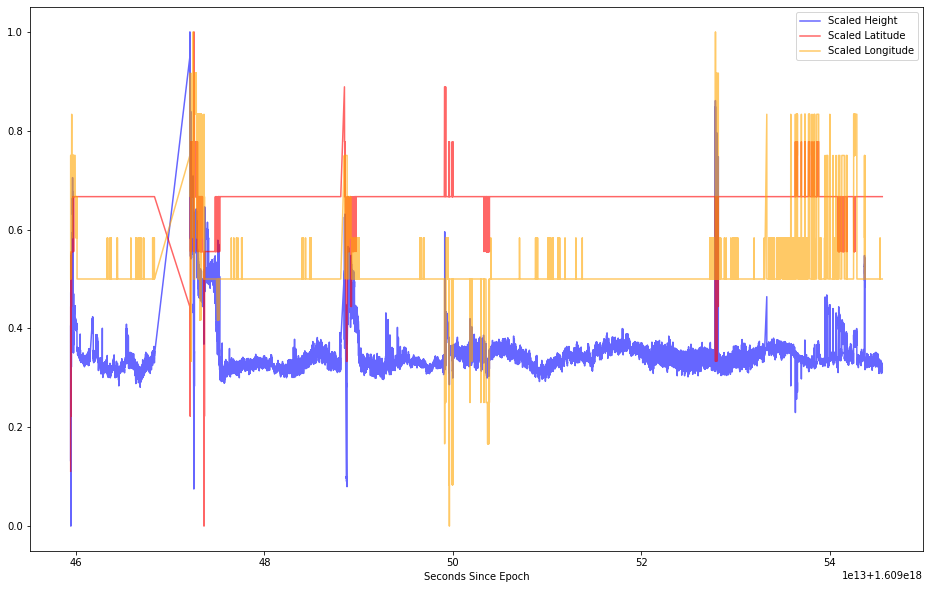

In [12]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.6

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Height', color='blue',ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Latitude', color='red', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Longitude', color='orange', ax=ax, alpha=alpha)

plt.show()

In [13]:
# Treating the individual fields as a vector, calculate the scalar value as a derived feature
fields_list = ['Scaled Height', 'Scaled Latitude', 'Scaled Longitude']

scaled_data["Average Scalar"] = calculate_scalar(scaled_data, fields_list, scale_minimum, scale_maximum)

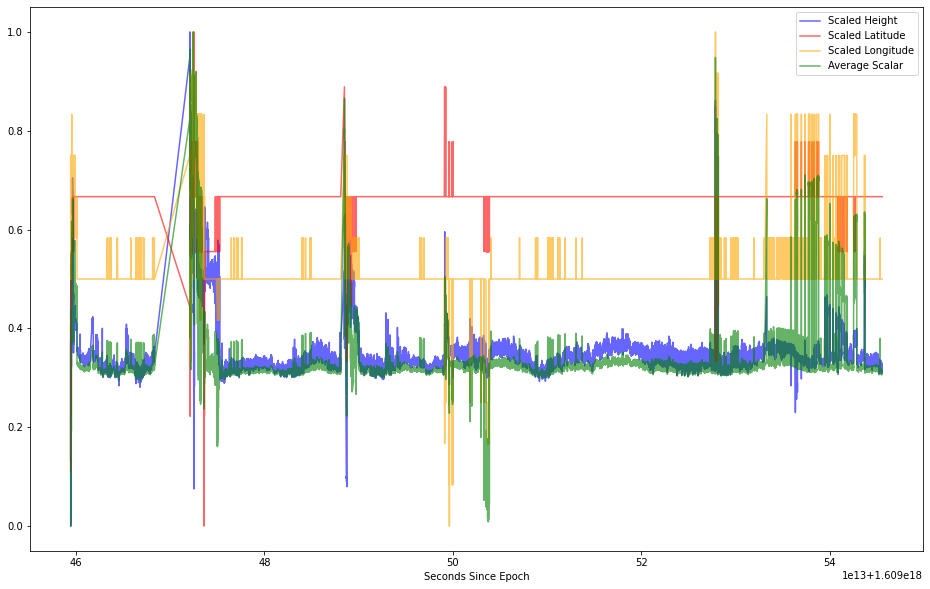

In [14]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.6

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Height', color='blue',ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Latitude', color='red', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Longitude', color='orange', ax=ax, alpha=alpha)

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Average Scalar', color='green', ax=ax, alpha=alpha)

plt.show()

In [15]:
scaled_data.keys()

Index(['Seconds Since Epoch', 'Scaled Height', 'Scaled Latitude',
       'Scaled Longitude', 'Average Scalar'],
      dtype='object')

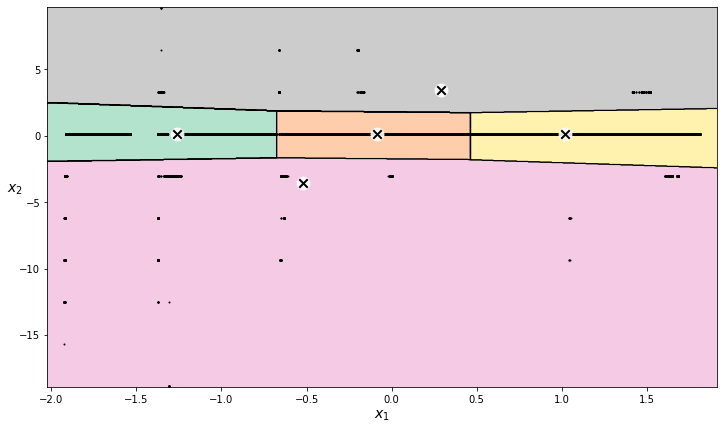

In [16]:
field_to_analyze = 'Scaled Latitude'
number_of_clusters = 5

# Impute the data 
data_imputed = transform_data_for_kmeans(scaled_data, field_to_analyze)

# Train the Kmeans model
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)

y_pred = kmeans.fit_predict(data_imputed)

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(kmeans, data_imputed)
plt.show()

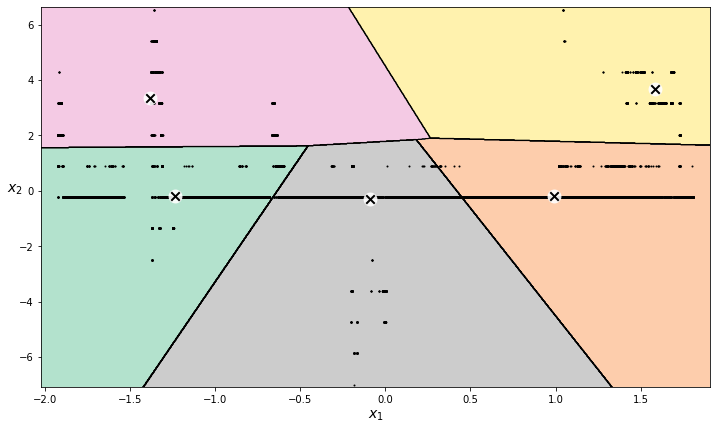

In [26]:
field_to_analyze = 'Scaled Longitude'
number_of_clusters = 5


# Impute the data 
data_imputed = transform_data_for_kmeans(scaled_data, field_to_analyze)

# Train the Kmeans model
kmeans = KMeans(n_clusters=number_of_clusters, random_state=41)

y_pred = kmeans.fit_predict(data_imputed)

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(kmeans, data_imputed)
plt.show()

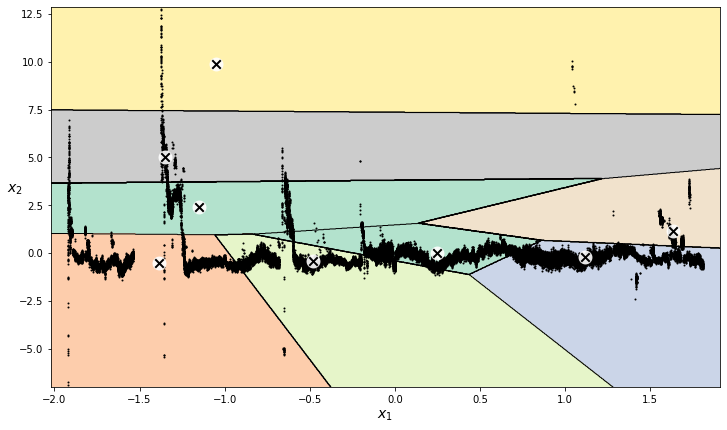

In [23]:
field_to_analyze = 'Scaled Height'
number_of_clusters = 8

# Impute the data 
data_imputed = transform_data_for_kmeans(scaled_data, field_to_analyze)

# Train the Kmeans model
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)

y_pred = kmeans.fit_predict(data_imputed)

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(kmeans, data_imputed)
plt.show()

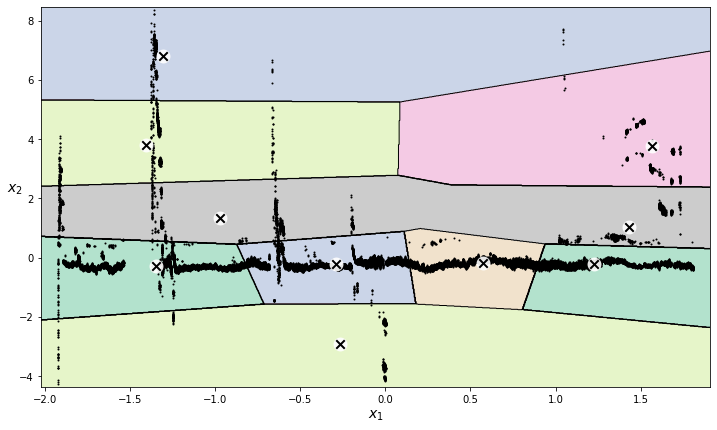

In [24]:
field_to_analyze = 'Average Scalar'
number_of_clusters = 10

# Impute the data 
data_imputed = transform_data_for_kmeans(scaled_data, field_to_analyze)

# Train the Kmeans model
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)

y_pred = kmeans.fit_predict(data_imputed)

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(kmeans, data_imputed)
plt.show()

In [63]:
y_pred.size

244348

In [68]:
data_imputed[:,0]

array([-1.73842104, -1.73841291, -1.73840479, ...,  1.77052501,
        1.77053314,  1.77054126])

In [70]:
data_imputed[:,:]

array([[-1.73842104, -4.12099214],
       [-1.73841291, -2.90012344],
       [-1.73840479, -2.88754355],
       ...,
       [ 1.77052501, -0.24275757],
       [ 1.77053314, -0.25764086],
       [ 1.77054126, -0.22287678]])